# Prueba de paso de modelo de pytorch a fastai
Vamos a probar a pasar un modelo sencillo definido en pytorch a fastai y usar los métodos de fastai


In [120]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

import torchvision
from fastai import *
from fastai.vision.all import *

In [121]:
def es_correcta(imagen): return imagen[8] == 'B'

In [122]:
path = Path('/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo3/Completo/')
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.3, bs=10, seed=43,
    label_func=es_correcta
)

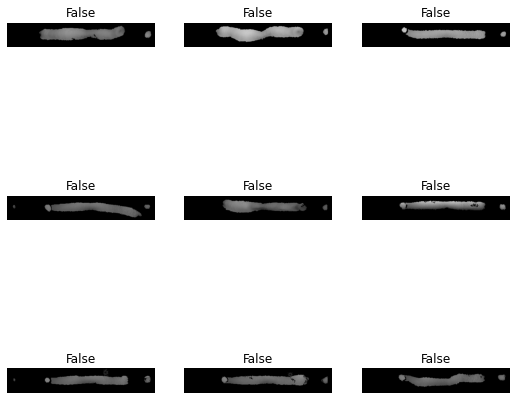

In [123]:
dls.show_batch()

In [124]:
class ModeloSimple(nn.Module):
    def __init__(self):
        super(ModeloSimple, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 17 * 117 , 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [125]:
model = ModeloSimple().cuda()
loss_func = nn.CrossEntropyLoss()
learn = Learner(dls, ModeloSimple(), loss_func=loss_func , metrics=accuracy)

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0020892962347716093)

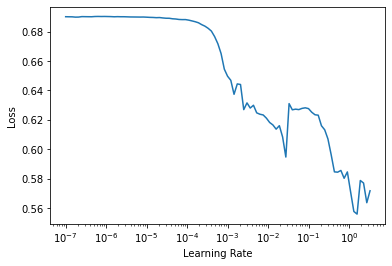

In [126]:
learn.lr_find()

In [127]:
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.343875,0.355855,0.840959,00:12
1,0.264324,0.256042,0.881730,00:12
2,0.211707,0.200626,0.913788,00:12


In [128]:
learn.model

ModeloSimple(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=31824, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)

## Se necesita crear un show_results() customizado

In [129]:
def show_results(learn,start=0, n=10,figsize=(10,25)):
    x = learn.dls.one_batch()
    with torch.no_grad():
        z = learn.model.eval()(imagenes[0])
    _, axs = plt.subplots(n, figsize=figsize)
    
    

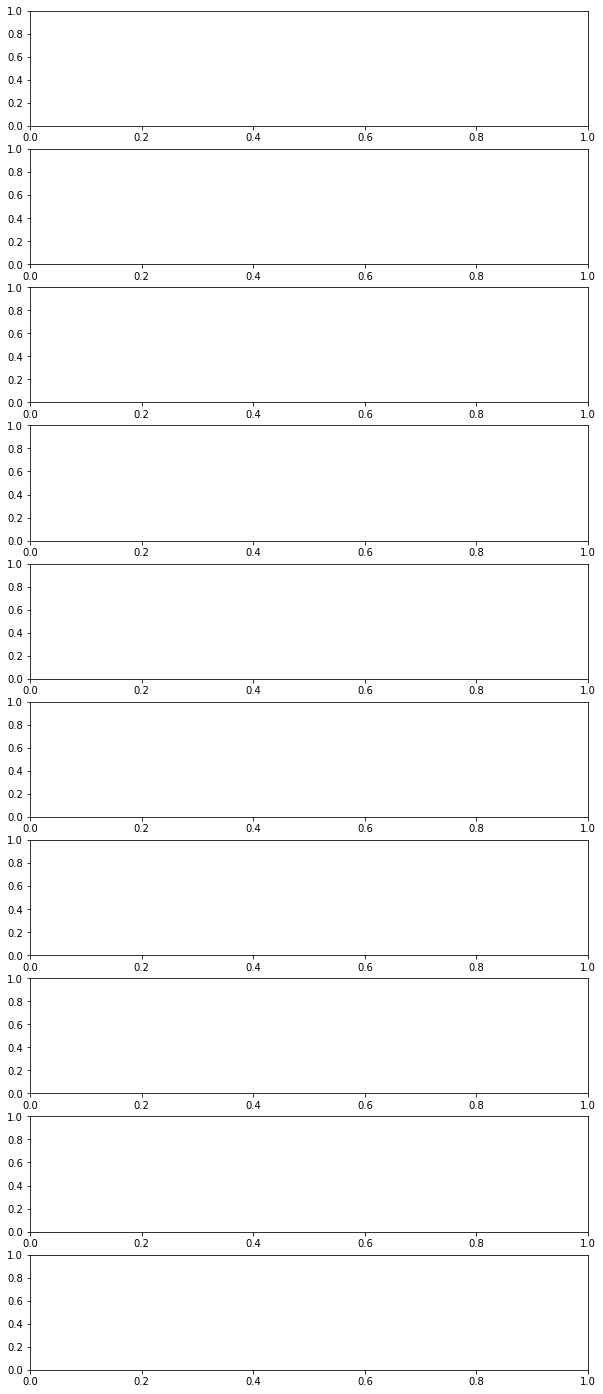

In [130]:
show_results(learn)

In [133]:
imagenes = learn.dls.one_batch()
#One batch te devuelve una lista con los tensores de las imagenes
# de un bath junto con una lista del mismo numero de 
# TensorCategory que te indica la categoria de la imagen.

# print(imagenes[0][11])
with torch.no_grad():
    z = learn.model.eval()(imagenes[0])
    print(z)
for i in z:
    print(torch.sigmoid(i))

tensor([[10.0503,  0.3390],
        [ 9.2957,  0.3296],
        [-3.0865, -1.6939],
        [ 0.5266, -1.8560],
        [ 8.6294,  0.3213],
        [-3.4639, -1.2063],
        [17.1722,  0.4275],
        [ 7.6804,  0.3095],
        [-0.5712, -1.1075],
        [ 4.0758,  0.3849]], device='cuda:0')
tensor([1.0000, 0.5839], device='cuda:0')
tensor([0.9999, 0.5817], device='cuda:0')
tensor([0.0437, 0.1553], device='cuda:0')
tensor([0.6287, 0.1352], device='cuda:0')
tensor([0.9998, 0.5796], device='cuda:0')
tensor([0.0304, 0.2304], device='cuda:0')
tensor([1.0000, 0.6053], device='cuda:0')
tensor([0.9995, 0.5768], device='cuda:0')
tensor([0.3610, 0.2483], device='cuda:0')
tensor([0.9833, 0.5951], device='cuda:0')


Creo que al aplicar el sigmoide obtenemos 10 tensores con la certeza que tiene la red de que cada una de estas imagenes son incorrectas o correctas, creo que el primer campo se refiere a las incorrectas y el segundo a las correctas. Esto hay que comprobarlo escogiendo una imagen del dataset y viendo como la evalua.